<a href="https://colab.research.google.com/github/tamtran4869/media_effectiveness_analysis/blob/main/MMM_lightweightMMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Mix Model with LightweightMMM

Purpose: To model and measure effects of media channels on sales and make marketing budget allocation decision using `lightweight_mmm`

It is interesting that `lightweight_mmm` uses Bayesian approach to model data.

## Install and load libraries

In [ ]:
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git
!pip install --upgrade git+https://github.com/pyro-ppl/numpyro.git


  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-77f_ext8
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-77f_ext8
  Resolved https://github.com/google/lightweight_mmm.git to commit f61a18b9883c2dccac8e360970935e3b6ee8265e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 21.5 MB/s eta 0:00:00
  Created wheel for lightweight-mmm: filename=lightweight_mmm-0.1.9-py3-none-any.whl size=105258 sha256=bea36f817133e07dbb4fb4b7ebd1180e07b9bae36be99c049c42a19a3e1e3726
  Stored in directory: /tmp/pip-ephem-wheel-cache-620machy/wheels/24/39/b1/2a08aa08bb7f10163332e54a87e860efd8f74fe42f4b93f9e2
Successfully built lightweight-mmm
  Attempting uninstall: matplotlib
    Found existing installa

  Cloning https://github.com/pyro-ppl/numpyro.git to /tmp/pip-req-build-rce57n5x
  Running command git clone --filter=blob:none --quiet https://github.com/pyro-ppl/numpyro.git /tmp/pip-req-build-rce57n5x
  Resolved https://github.com/pyro-ppl/numpyro.git to commit cc1ad02c5aab0586a5a613ef6f2516d5f8848b10
  Preparing metadata (setup.py) ... done


In [ ]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
numpyro.set_host_device_count(2)

# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import media_transforms, models
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


## Load and clean data

In [ ]:
# Load data
df = pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

# Media data features
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']

# Control features
hldy_cols = [col for col in df.columns if 'hldy_' in col]
seas_cols = [col for col in df.columns if 'seas_' in col]
control_vars =  hldy_cols + seas_cols

# KPI feature
sales_cols =['sales']

# Combine and rename
df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]
df_main['wk_strt_dt'] = pd.to_datetime(df_main['wk_strt_dt'])
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]


In [ ]:
df_main.head()

,wk_strt_dt,sales,Direct Mail,Insert,Newspaper,Radio,TV,Social Media,Online Display,hldy_Black Friday,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,72051457.64,678410.26,129759.66,507635.16,254134.14,216725.59,0.0,61364.75,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,78794770.54,661097.71,70355.33,625719.37,106602.98,108919.26,0.0,132643.90,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,70071185.56,1874338.43,107720.37,277532.61,59011.42,74032.19,0.0,76741.27,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,68642464.59,306583.37,141708.61,186028.61,178010.46,110995.66,0.0,193043.55,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,86190784.65,2366274.16,160691.30,706694.09,144097.56,225140.84,0.0,249612.89,0,...,0,0,0,0,0,0,0,0,0,0


## Prepare datasets
From `df_main`, extract the following:

* `media_data`: features related to media performance on each channel, such as views, impressions, clicks, or in this case, ad spends.
* `extra_features`: additional features that may impact the KPI, such as holidays or seasonal factors.
* `costs`: the total ad spend for each channel over time, providing prior knowledge about media.
* `target`: the KPI, in this case, sales.

In [ ]:
data_size = len(df_main)
n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

In [ ]:
# Split and scale data.
test_data_period_size = 10
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Cost
costs = df_main[mdsp_cols].iloc[:split_point, ...].sum().to_numpy()
costs_test = df_main[mdsp_cols].iloc[split_point:, ...].sum().to_numpy()

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]
target_test = target[split_point:, ...]

In [ ]:
# Init scaler
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by = 0.15)
# Fit and transform train data using scalers
media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

## Check data quality
It is convenient when `lightweight_mmm` package has functions to check correlations, variance, spend fractions and variance inflation factors (VIF).

In [ ]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features))

## LightweightMMM model

The model employs a Bayesian approach to capture various factors affecting sales, including organic changes, additional factors, trend, seasonality, and media effects. Unlike traditional frequentist approaches that provide a single coefficient for each factor, the Bayesian model generates a distribution (posterior distribution) for each coefficient. For instance:

* Frequentist: The coefficient for TV ad views is determined as 0.04, indicating that a single view from TV ads contributes to a 0.04 increase in sales.
* Bayesian: The coefficient for TV ad views follows a normal distribution with a mean of 0.06 and a variance of 0.04. This implies that the coefficient could range from 0.04 to 0.08. To make predictions or inferences, Markov Chain Monte Carlo (MCMC) sampling is used to draw samples from this distribution. The Bayesian approach is particularly advantageous in handling uncertainty.


To address saturation and lagging effects of media, the `lightweightmmm` package offers three approaches: hill_adstock, adstock, and carryover. We can understand that each approach has different formular with different coefficients to calculate effect of media.
* Saturation refers to the phenomenon where sales growth slows down and fails to increase proportionally with media spending.
* Lagging effect suggests that media impact on sales may not be immediate, with media at time t potentially influencing sales at time t+1 and beyond.

Detailed formulas for each approach can be found in the provided source/reference.


sample: 100%|██████████| 2000/2000 [03:36<00:00,  9.26it/s, 1023 steps of size 1.94e-03. acc. prob=0.90]


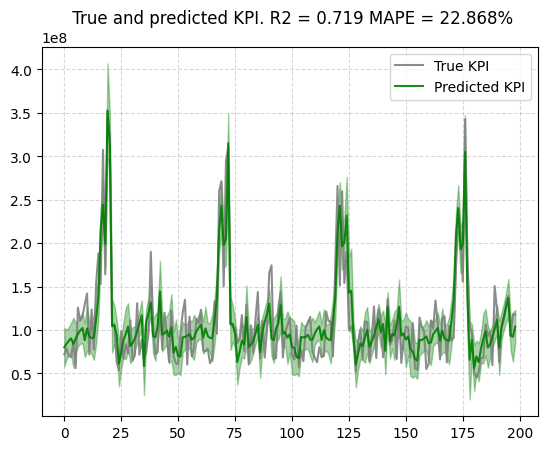

In [ ]:
SEED = 123
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit(media=media_data_train,
        media_prior=costs,
        target=target_train,
        extra_features=extra_features_train,
        number_warmup=1000, # For MCMC
        number_samples=1000, # For MCMC
        degrees_seasonality = 2, #default
        seed=SEED,
        number_chains=1)
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

Another difference between frequentist and Bayesian is that Bayesian allows the use of prior knowledge about the effects in the model. For example, in this case, we assume that from previous campaigns, we observed the organic increase/baseline sales (without media and other factors) to range from 0 to 1.5. We can then customize a prior distribution for the `intercept`, such as a half-normal distribution with a scale of 1.5.

We also tune the parameter `degrees_seasonality` and the prior for seasonality.

sample: 100%|██████████| 2000/2000 [04:12<00:00,  7.91it/s, 1023 steps of size 1.64e-03. acc. prob=0.93]


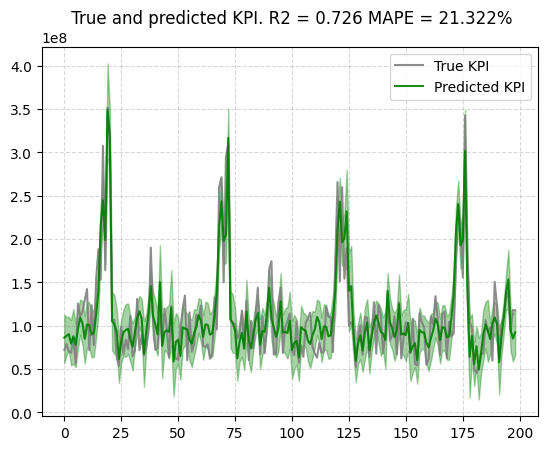

In [ ]:
custom_priors = {"gamma_seasonality":numpyro.distributions.Normal(loc=0.5, scale=2),
                 "intercept":numpyro.distributions.HalfNormal(scale=1.5)
                 }
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit(media=media_data_train,
        media_prior=costs,
        target=target_train,
        extra_features=extra_features_train,
        number_warmup=1000,
        number_samples=1000,
        seed=SEED,
        number_chains=1,
        degrees_seasonality = 10,
        custom_priors=custom_priors
        )
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

We can examine the statistics of the coefficients by drawing 1000 samples from the posterior distribution using MCMC:

In [ ]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.03      0.82     -0.03     -1.18      1.55    213.46      1.00
             coef_extra_features[1]     -0.05      0.68     -0.07     -1.12      1.08    175.42      1.00
             coef_extra_features[2]     -0.01      0.01     -0.01     -0.03     -0.00    265.29      1.00
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01    555.03      1.00
             coef_extra_features[4]      0.04      0.69      0.06     -1.09      1.14    185.38      1.00
             coef_extra_features[5]      0.06      0.68      0.08     -1.05      1.15    175.38      1.00
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01     -0.00    463.10      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00    594.59      1.00
             coef_extra_features[8]     -0.02

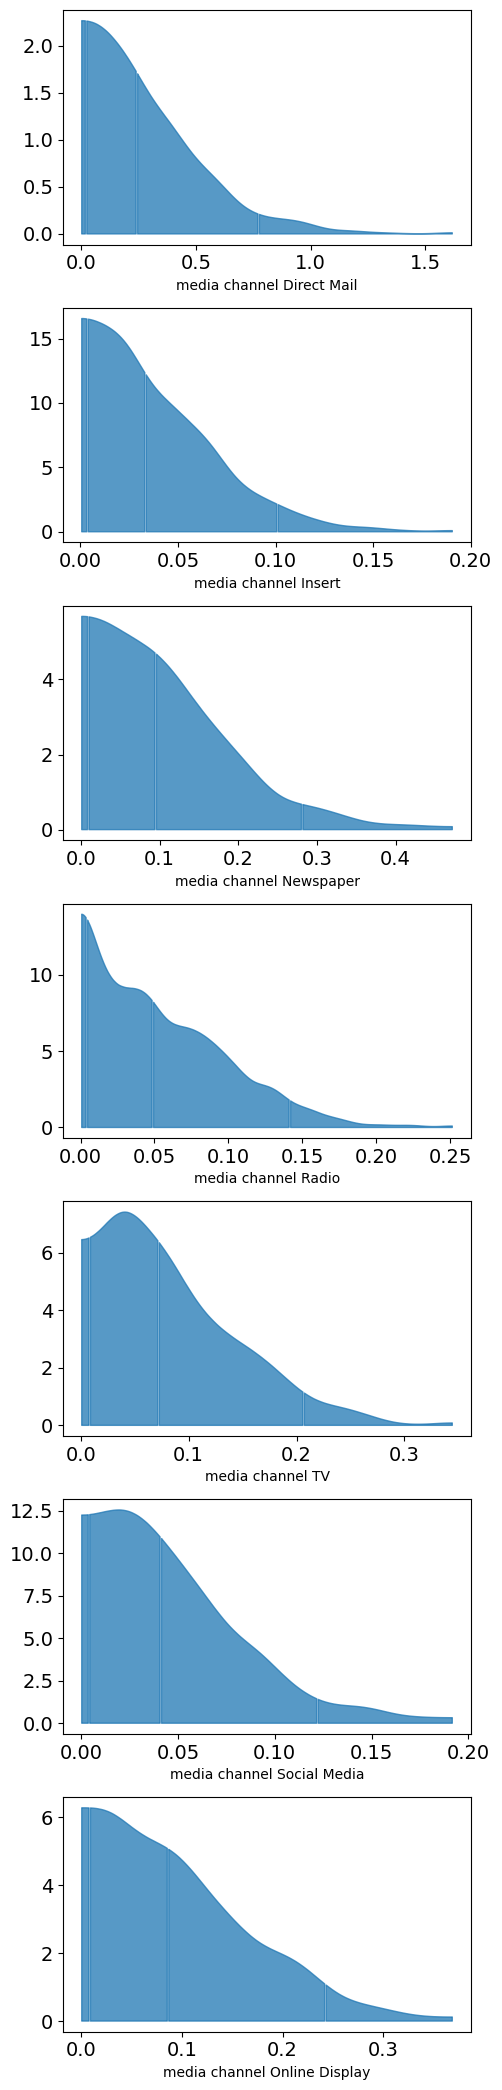

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

To see contribution of media channels and baseline over the time:

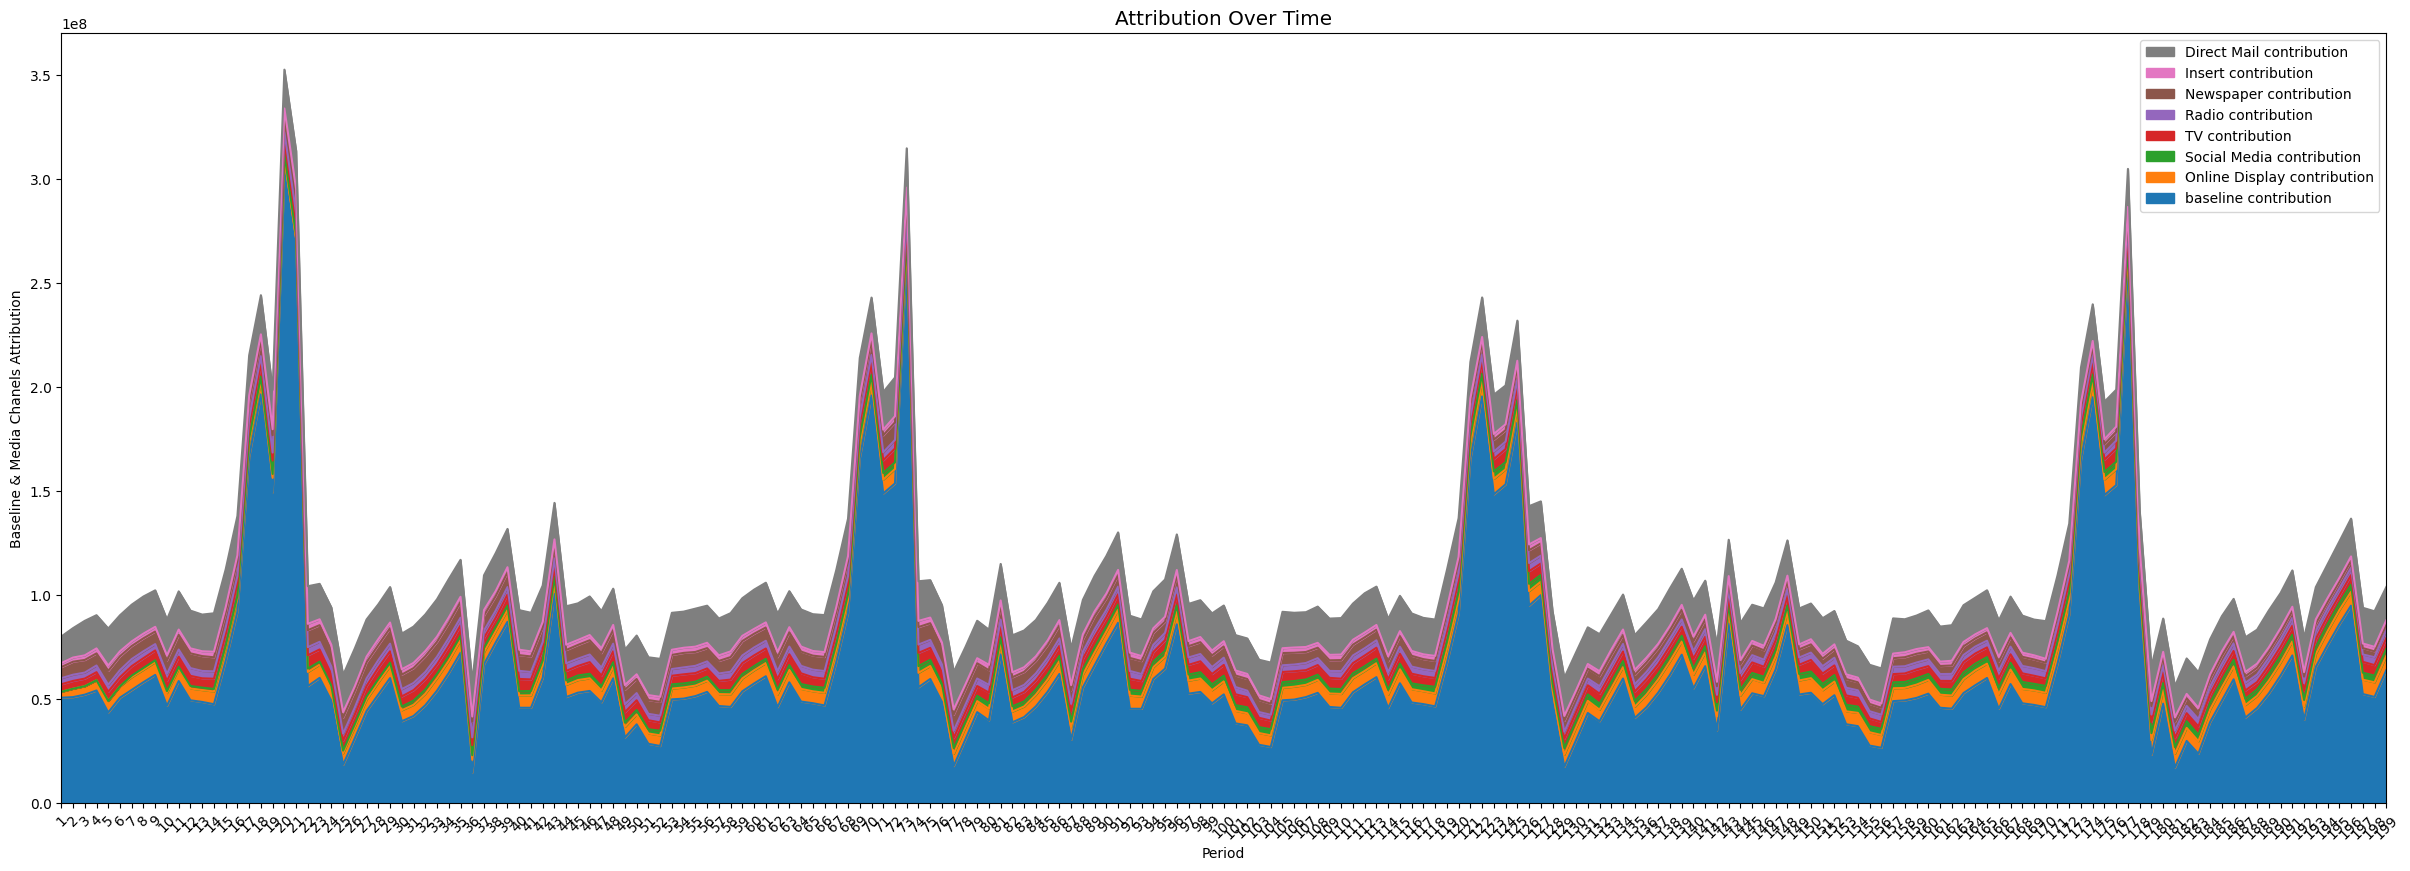

In [ ]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols)

To check media effects and ROI:

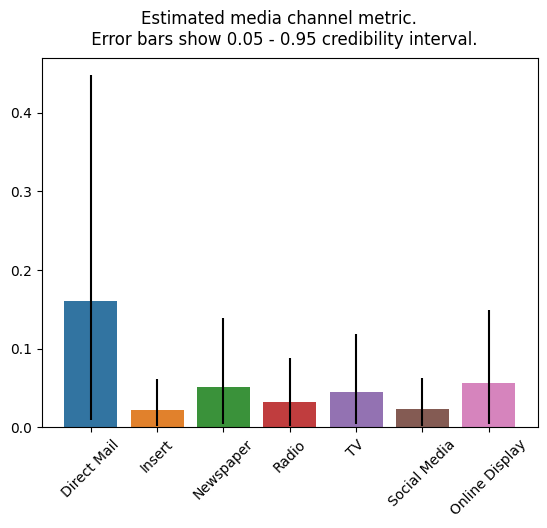

In [ ]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler)
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=mdsp_cols)

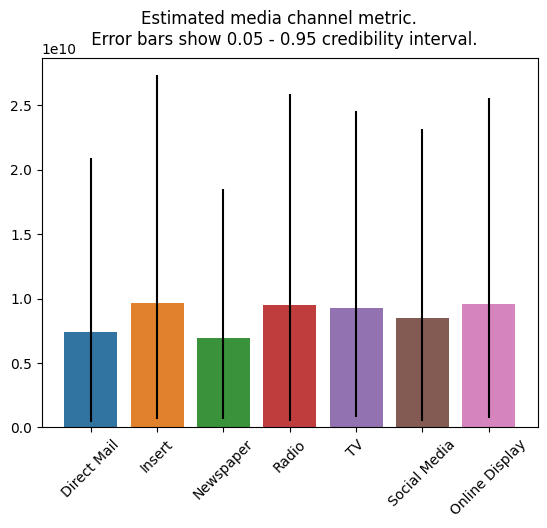

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=mdsp_cols)

To check whether media channels reach the point of saturation:

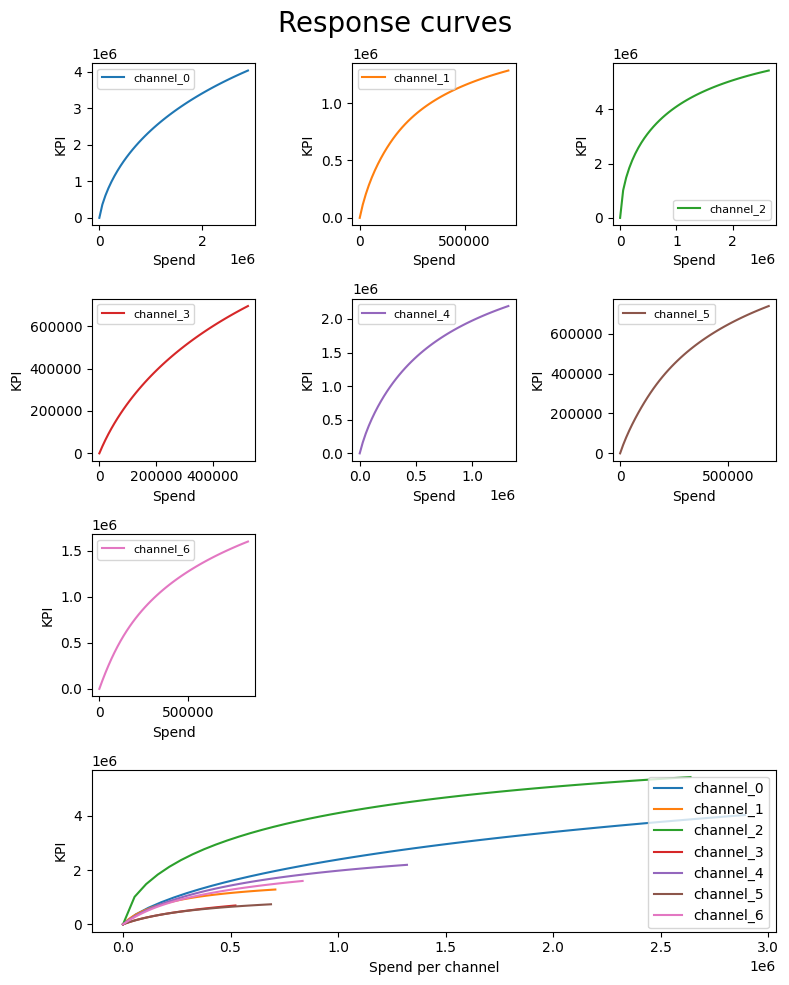

In [ ]:
plot.plot_response_curves(media_mix_model=mmm,
                          media_scaler=media_scaler,
                          target_scaler=target_scaler)


To predict:

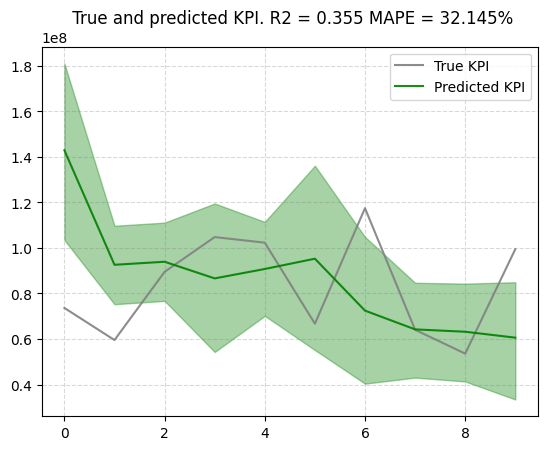

In [ ]:
prediction = mmm.predict(
    media = media_scaler.transform(media_data_test),
    extra_features=extra_features_scaler.transform(extra_features_test),
    target_scaler=target_scaler,
    seed = SEED
)

plot.plot_out_of_sample_model_fit(out_of_sample_predictions=prediction,
                                 out_of_sample_target=target_test)

Note that `lightweightMMM` does not focus on forecasting, it focused on MMM.

## Budget allocation
In this section, we will compare the suggested optimal allocation with two other approaches:

* The allocation based on the spend fractions of the training dataset.
* The actual allocation used in the last 10 weeks.

To do this, we set the budget to be the same as the total cost of the last 10 weeks, and n_time_periods to 10.

We also set the prices for all channels to 1, as our media data already represents ad spend. For example, if the media data is in terms of clicks, then the prices should be interpreted as the cost per click.


In [ ]:
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = 10
budget = costs_test.sum()#jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods
budget

10571573.19

In [ ]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test),
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED,
    bounds_lower_pct= 0.5)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -888118258.3246582
            Iterations: 76
            Function evaluations: 1125
            Gradient evaluations: 75


In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([3889650.  ,  708511.06, 1847456.9 ,  684379.2 , 1443768.2 ,
        526989.8 , 1470818.  ], dtype=float32)

In [ ]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([4746124.5 ,  497346.03, 1630990.6 ,  751785.5 , 1050653.1 ,
        601550.3 , 1293122.6 ], dtype=float32)

Compare with the same allocation fraction with the train data and the optimal allocation:

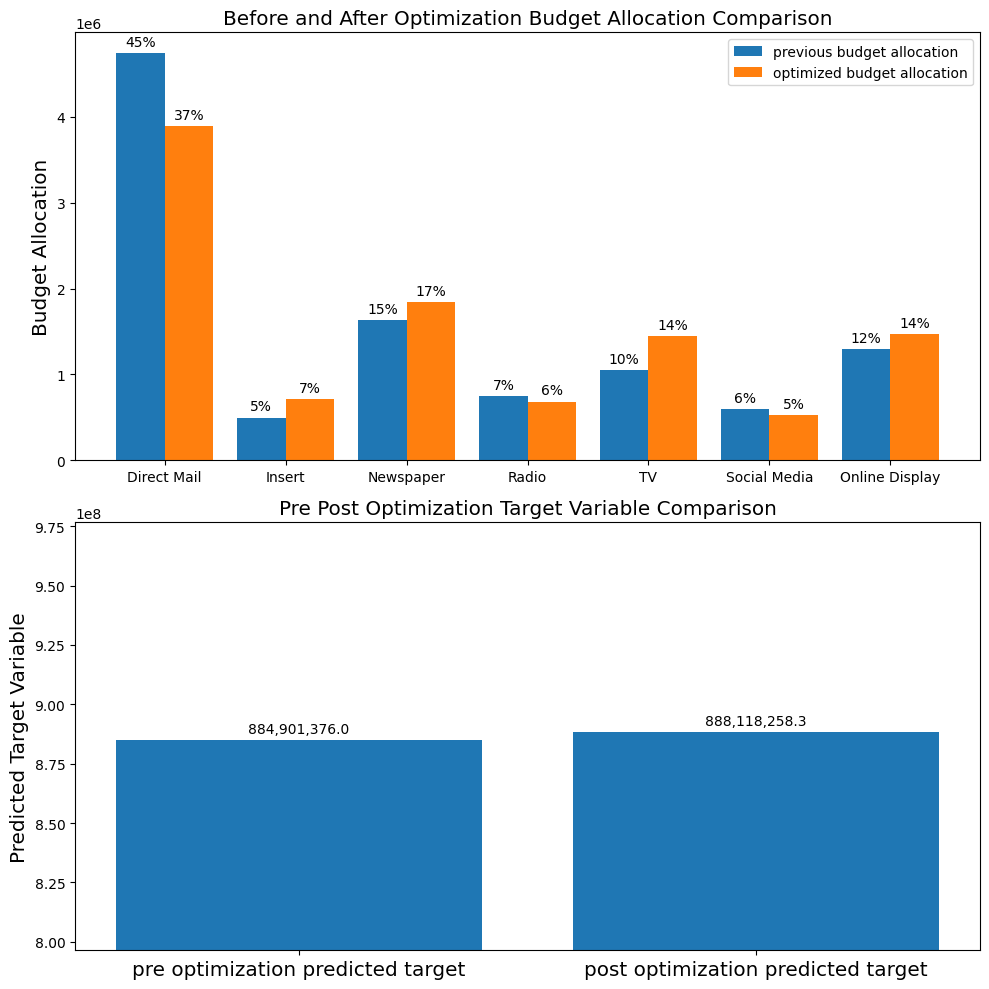

In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim = kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation = previous_budget_allocation,
                                                channel_names = mdsp_cols,
                                                figure_size=(10,10))

Compare between the real allocation used and the optimal allocation:

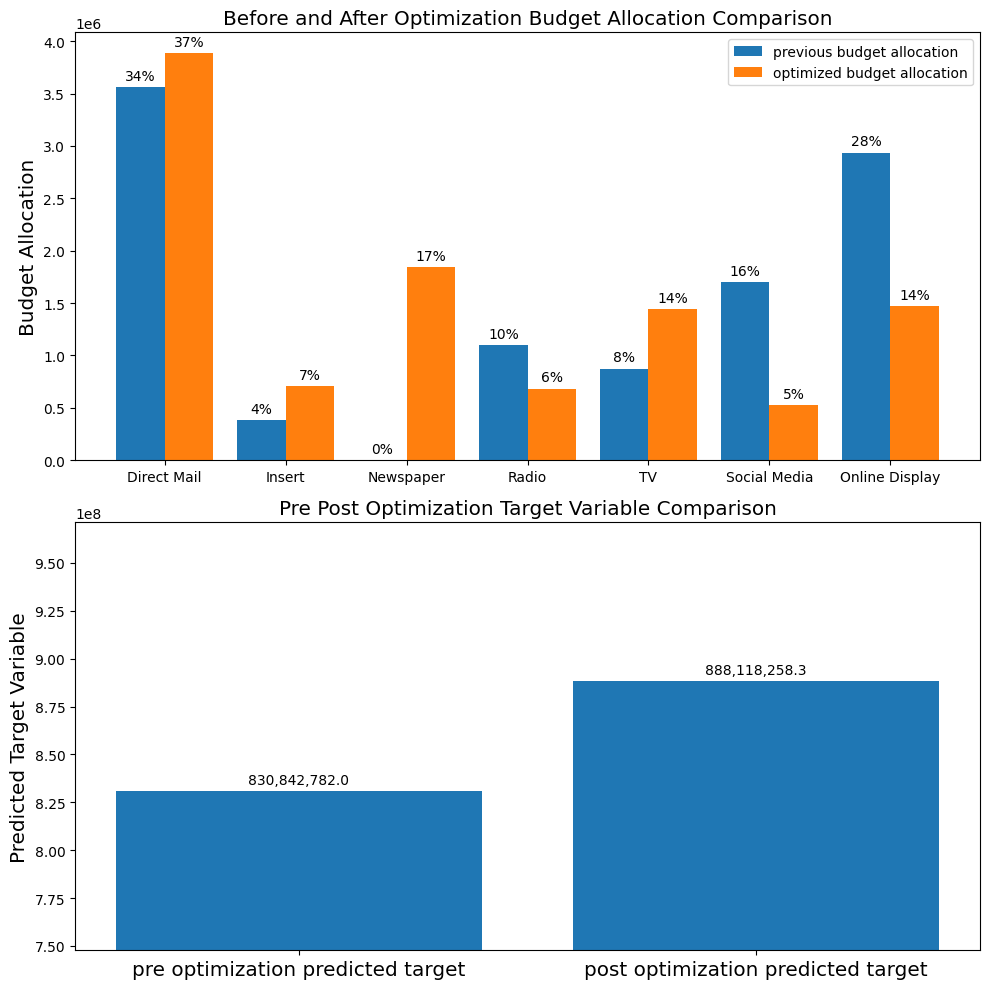

In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim = -1*target_test.sum(),#kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation = costs_test,#previous_budget_allocation,
                                                channel_names = mdsp_cols,
                                                figure_size=(10,10))

The optimal allocation helps increase sales.

## REFERENCES:

https://lightweight-mmm.readthedocs.io/en/latest/index.html

https://github.com/google/lightweight_mmm/tree/main/examples

https://medium.com/@xijianlim/tunable-lightweight-mmm-using-googles-new-mixed-marketing-models-with-added-functions-eb89962205b2

https://towardsdatascience.com/media-mix-modeling-how-to-measure-the-effectiveness-of-advertising-with-python-lightweightmmm-b6d7de110ae6

A very clear series of lectures about Bayesian statistics: https://www.youtube.com/watch?v=y8tTsGCSvMg&list=PL_lWxa4iVNt2GBPOVZMVKD4jYl9Q7hs2K
